In [1]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle competitions download -c dogs-vs-cats

 99% 538M/543M [00:02<00:00, 249MB/s]
100% 543M/543M [00:02<00:00, 230MB/s]
 99% 269M/271M [00:01<00:00, 260MB/s]
100% 271M/271M [00:01<00:00, 242MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 87.9MB/s]


In [3]:
from zipfile import ZipFile
file_name = r'/content/train.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
import os, glob, shutil
from random import sample
from tqdm import tqdm

In [5]:
os.chdir(r'/content/train/')

if os.path.isdir('train/dog') is False:
  os.makedirs('train/dog')
  os.makedirs('train/cat')
  os.makedirs('valid/dog')
  os.makedirs('valid/cat')

  for c in tqdm(sample(glob.glob('cat*'),10625)):
    shutil.move(c, 'train/cat')
  for c in tqdm(sample(glob.glob('dog*'),10625)):
    shutil.move(c, 'train/dog')
  for c in tqdm(sample(glob.glob('cat*'),1875)):
    shutil.move(c, 'valid/cat')
  for c in tqdm(sample(glob.glob('dog*'),1875)):
    shutil.move(c, 'valid/dog')

os.chdir('/content/')

100%|██████████| 1875/1875 [00:00<00:00, 31229.68it/s]


In [6]:
train_path = r'/content/train/train'
valid_path = r'/content/train/valid'

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from matplotlib.image import imread
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [8]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)

In [9]:
X_train = train_datagen.flow_from_directory(train_path,
                                            target_size=(224,224),
                                            color_mode="rgb",
                                            batch_size=64,
                                            class_mode="binary")

X_valid = valid_datagen.flow_from_directory(valid_path,
                                            target_size=(224,224),
                                            color_mode="rgb",
                                            batch_size=64,
                                            class_mode="binary")

Found 21250 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


In [10]:
model = Sequential()

model.add(Conv2D(filters = 32,kernel_size=[3,3], padding = 'same',
                 input_shape = (224,224,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 64,kernel_size=[3,3], padding = 'same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 128,kernel_size=[3,3], padding = 'same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 256,kernel_size=[3,3], padding = 'same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics =['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2

In [12]:
early_stop = EarlyStopping(monitor='val_loss', mode = "min", patience=3, restore_best_weights=True)

In [13]:
model.fit(X_train,validation_data = X_valid,epochs = 20,callbacks = [early_stop])

Epoch 1/20
333/333 [==============================] - 266s 777ms/step - loss: 0.7014 - accuracy: 0.5214 - val_loss: 0.6336 - val_accuracy: 0.6165
Epoch 2/20
333/333 [==============================] - 259s 778ms/step - loss: 0.6018 - accuracy: 0.6744 - val_loss: 0.4992 - val_accuracy: 0.7619
Epoch 3/20
333/333 [==============================] - 259s 777ms/step - loss: 0.5063 - accuracy: 0.7564 - val_loss: 0.4515 - val_accuracy: 0.7909
Epoch 4/20
333/333 [==============================] - 260s 781ms/step - loss: 0.4498 - accuracy: 0.7881 - val_loss: 0.4179 - val_accuracy: 0.8157
Epoch 5/20
333/333 [==============================] - 262s 786ms/step - loss: 0.4129 - accuracy: 0.8115 - val_loss: 0.3740 - val_accuracy: 0.8291
Epoch 6/20
333/333 [==============================] - 262s 788ms/step - loss: 0.4127 - accuracy: 0.8134 - val_loss: 0.3580 - val_accuracy: 0.8421
Epoch 7/20
333/333 [==============================] - 263s 790ms/step - loss: 0.3384 - accuracy: 0.8469 - val_loss: 0.3378 -

In [14]:
model.save('dogs-vs-cats.h5')

In [15]:
model.save_weights("dogs-vs-cats-weights.h5")

In [16]:
model_json = model.to_json()
with open("dogs-vs-cats-model.json", "w") as json_file:
  json_file.write(model_json)

In [17]:
losses = pd.DataFrame(model.history.history)

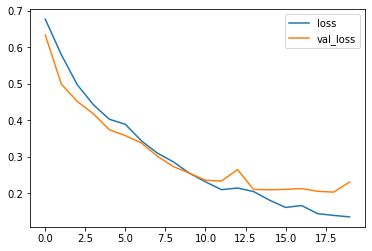

In [18]:
losses[['loss', 'val_loss']].plot()

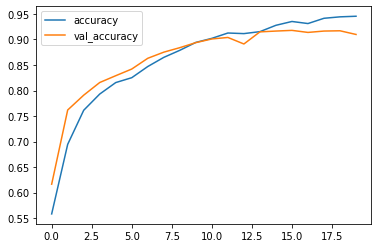

In [21]:
losses[['accuracy', 'val_accuracy']].plot()

In [142]:
sample_img = load_img('/content/dog.jpg', target_size=(224,224))

In [143]:
sample_img_array = img_to_array(sample_img)

In [144]:
sample_img = np.array(sample_img_array)

In [145]:
sample_img = sample_img/255.0

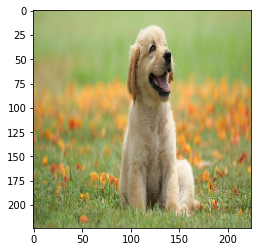

In [146]:
plt.imshow(sample_img)

In [147]:
np.argmax(model.predict(sample_img.reshape(1,224,224,3)), axis=-1)

array([0])

In [148]:
model.predict(sample_img.reshape(1,224,224,3))

array([[0.99976903]], dtype=float32)

In [149]:
sample_img = load_img('/content/test.jpeg', target_size=(224,224))

In [150]:
sample_img_array = img_to_array(sample_img)

In [151]:
sample_img_array = img_to_array(sample_img)

In [152]:
sample_img = np.array(sample_img_array)

In [153]:
sample_img = sample_img/255.0

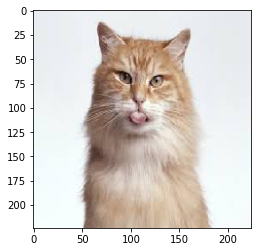

In [154]:
plt.imshow(sample_img)

In [155]:
np.argmax(model.predict(sample_img.reshape(1,224,224,3)), axis=-1)

array([0])

In [156]:
model.predict(sample_img.reshape(1,224,224,3))

array([[6.542749e-07]], dtype=float32)